In [6]:
%matplotlib notebook
    # this allows matplotlib output to be zoomed and shown at a larger size than in-line plots.
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
    # note: per https://stackoverflow.com/questions/11312579/networkx-draw-networkx-edges-capstyle ,
    # you can't set solid line capstyle in line collections (e.g. .plot)  But you can set them for
    # individually created Line2D items.  I want 'butt' style, stopping exactly at the point.
import math
import pandas as pd

peaksFileName = "../data/combined_peaktable_blue_only.csv"
peakData = pd.read_csv(peaksFileName)
colNames = list(peakData.columns)
print("list of column names: ", colNames)

# shorthands for column names for peak beginning and ending points (in bp).
BeginBpCol = colNames[13]
EndBpCol = colNames[14]

# for the other useful columns, I will use the direct strings: 'well', 'celltype', Size', 'Height'



list of column names:  ['code', 'well', 'celltype', 'Sample Filename', 'Dye Color', 'Dye, Sample Peak', 'Size', 'Height', 'Area (Data Point)', 'Area (Base Pairs)', 'Data Point', 'Begin Point (Data Point)', 'End Point (Data Point)', 'Begin Point (Base Pairs)', 'End Point (Base Pairs)']


In [7]:
# laneDict is a dict of lanes, indexed by code.
# a 'lane' is a dict with these keys: {well, celltype, bandList} where bandList maps to a list of bands.
# a 'band' is a dict with these keys: {SizeBp, Height, beginBp, endBp}

# accumulate lanes from peakData.
laneDict = {}
for i in peakData.index:
    currCode = peakData.loc[i,'code']
    bandKeys = ['SizeBp', 'Height', 'beginBp', 'endBp']
    dataKeys = ['Size', 'Height', BeginBpCol, EndBpCol]
    currBand = dict(zip(bandKeys, list(peakData.loc[i, dataKeys])))
    if currCode not in laneDict:
        # initialize this lane
        laneDict[currCode] = {'code': currCode, 'celltype': peakData.at[i,'celltype'], 'bandList': []}
    laneDict[currCode]['bandList'].append(currBand)


In [8]:
def drawBand( xStart, xWidth, center, spread, intensity, yStep=0.1, blackBands=True ):
    absIntensity = (1.0 - intensity) if blackBands else intensity
    maxi = int(spread/2.0/yStep + 0.5)
    # assume that spread/2 is two standard deviations
    sigma = spread/2.0/2.0
    for i in range(maxi):
        yAbove = center + i*yStep
        yBelow = center - (i+1)*yStep
        absiIntensity = absIntensity*math.exp(-float((yAbove - center) ** 2) / (sigma ** 2))
        iIntensity = (1.0 - absiIntensity) if blackBands else absiIntensity
        #iIntensity = intensity + (1.0 - intensity)*i/maxi  #linear intensity drop
        rectAbove = plt.Rectangle((xStart, yAbove), xWidth, yStep, fc=str(iIntensity))
        rectBelow = plt.Rectangle((xStart, yBelow), xWidth, yStep, fc=str(iIntensity))
        plt.gca().add_patch(rectAbove)
        plt.gca().add_patch(rectBelow)
    return;

<IPython.core.display.Javascript object>


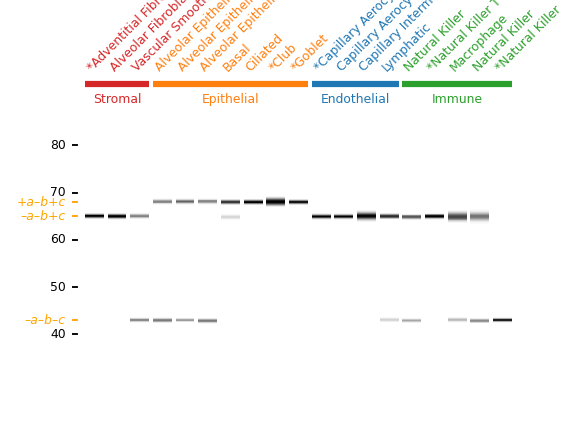

In [9]:
codeOrder = ['Str1', 'Str3', 'Str6',
             'Epi2', 'Epi3', 'Epi4', 'Epi5', 'Epi6', 'Epi7', 'Epi8',
             'End2', 'End3', 'End4', 'End6',
             'Imm2', 'Imm3', 'Imm4', 'Imm6', 'Imm7']

numLanes = len(codeOrder)
laneWidth = 40
laneGap = 8
# include a gap preceding and following the last lane, as well as between lanes
gelWidth = numLanes * (laneWidth + laneGap) + laneGap
gelLength = 100
labelBaseline = 95

# coefficients for linear transformation adjusting observed Size to expected Size
# (discrepancy is because DNA standards are ROX-labeled and samples are 6FAM-labeled, and the two
#  dyes have different charges.)
c1 = 1.1364    # slope
c2 = -4.1686   # intercept

# colors for text of different "compartments" (cell lineages)
compartFullName = {'Epi': 'Epithelial', 'End': 'Endothelial', 'Imm': 'Immune', 'Str': 'Stromal'}
# compartment colors (from Julia O.)
compartColor = {"End" : u'#1f77b4', "Epi" : u'#ff7f0e', "Imm" : u'#2ca02c',"Str" :  u'#d62728'}

plt.axes()

# Size key on left side of plot
sizeMarkers = [40, 50, 60, 70, 80]
for bp in sizeMarkers:
    plt.gca().plot([-3*laneGap, -1*laneGap], [bp, bp], color = 'black')
    plt.gca().text(-4*laneGap, bp, str(bp), ha = 'right', va = 'center')
# isoform key on left side, in red
isoformSizes = [('+a–b+c', 68), ('–a–b+c', 65), ('–a–b–c', 43)]
for (name, bp) in isoformSizes:
    plt.gca().plot([-3*laneGap, -1*laneGap], [bp, bp], color = 'orange')
    plt.gca().text(-4*laneGap, bp, name, color = 'orange', style = 'italic', ha = 'right', va = 'center')

# draw compartment groupings under the labels
# first compute the extent of each compartment grouping (assume compartments are contiguous)
currCompart = ""
compartCoord = {}
for code in codeOrder:
    if not currCompart:
        # first compartment
        currCompart = code[0:3]
        currStart = laneGap
        currEnd = currStart + laneWidth       
    elif currCompart != code[0:3]:
        # changing to new compartment
        currCompart = code[0:3]
        currStart = currEnd + laneGap
        currEnd = currStart + laneWidth
    else:
        # continuing same compartment
        currEnd = currEnd + laneGap + laneWidth
    compartCoord[currCompart] = [currStart, currEnd]
# draw compartment grouping lines and full-names
for compart, coord in compartCoord.items():
    lineStart = coord[0]
    lineEnd = coord[1]
    lineY = labelBaseline - 2
    cLine = Line2D([lineStart, lineEnd], [lineY, lineY], color = compartColor[compart],
                     linewidth = 5,solid_capstyle='butt')
    plt.gca().add_line(cLine)
    plt.gca().text((lineStart+lineEnd)/2, lineY - 4,
                   compartFullName[compart], color = compartColor[compart], ha = 'center')

    
# set of samples that were Sanger sequenced.
seqSet = {'Str1', 'Epi7', 'Epi8', 'End2', 'Imm3', 'Imm7'}

for i, code in enumerate(codeOrder):
    laneStart = laneGap + i * (laneWidth + laneGap)
    # lane labeled with 'celltype' at top, text per compartColor dict.
    textColor = compartColor[code[0:3]]
    textLabel = ('*' if code in seqSet else "") + laneDict[code]['celltype']
    plt.gca().text(laneStart, labelBaseline, textLabel,
                   color = textColor, ha = 'left', va = 'bottom', rotation = 45.0)
    bandList = laneDict[code]['bandList']
    # calculate sum of all peak heights, for normalizing intensity
    hList = [band['Height'] for band in laneDict[code]['bandList']]
    hSum = sum(hList)
    for band in bandList:
        # adjust Size using linear transformation
        yCenter = c1*band['SizeBp'] + c2
        # because we want black bands, subtract normalized height from 1.0
        normHeight = 1.0 - band['Height']/hSum
        # adjust ySpread using linear transformation (c2 cancels out so not used)
        ySpread = (band['endBp'] - band['beginBp'])*c1
        drawBand(laneStart, laneWidth, yCenter, ySpread, normHeight)


plt.axis([-20, gelWidth, 30, gelLength])
plt.axis('off')
plt.show()


In [10]:
outPath = "output/plotgel/"
outName = 'RPS24_isoform_PCR_figure'
# some problems:
# bbox_inches='tight' was necessary to get the PNG output to not truncate off the celltype labels.
# the PDF output doesn't open in Mac Preview, but opens fine in Adobe Acrobat Viewer (on Mac).
# the SVG output has unwanted reverse-L lines (like the bottom and right borders of a box) when opened in InkScape;
#     this reverse-L is not seen in the other two output formats.
plt.savefig(outPath + outName + '.pdf', bbox_inches='tight')
plt.savefig(outPath + outName + '.svg', bbox_inches='tight')
plt.savefig(outPath + outName + '.png', dpi=300, bbox_inches='tight')
